In [1]:
import fcsparser
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns
from random import sample
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import scikitplot as skplt
import matplotlib as mpl

# Data Import

In [2]:
path = os.path.join(os.getcwd(),"data","shedding","export")


In [3]:
genotype = ["WT","KO","KO","WT","WT","KO","WT","KO","WT"]

In [4]:
gt_dict = {idx:elm for idx,elm in enumerate(genotype)}

In [5]:
anti =["CD8","CD62L","CD3","IL6Ra","TNFa","unused","CD4","PacO"]
antibodies = anti.copy()
#order = [7,8,9,10,11,0,1,2,3,4,5,6]
#antibodies = [antibodies[i] for i in order]
antibodies.insert(0,"SSC_W")
antibodies.insert(0,"SSC_H")
antibodies.insert(0,"SSC_A")
antibodies.insert(0,"FSC_W")
antibodies.insert(0,"FSC_H")
antibodies.insert(0,"FSC_A")
antibodies.insert(0,"genotype")
antibodies.insert(0,"mousenr")
antibodies.insert(0,"stim")
antibodies.insert(0,"pop")
antibodies.append("time")

In [6]:
def read_fcs_data(path_sub, gt_dict, antibodies):
    
    df = pd.DataFrame()

    for elm in os.listdir(path_sub):
        temp_df = pd.DataFrame()
        file = os.path.join(path_sub, elm)

        meta, data = fcsparser.parse(file, meta_data_only=False, reformat_meta=True)
        elm_split = elm.split("_")
        split_first = elm_split[0].split(" ")
        temp_df["pop"] = [split_first[-1]]*len(data)
        temp_df["stim"] = [split_first[1]]*len(data)

        int_list = list(elm_split[2])
        gt = int(int_list[2])
        temp_df["mousenr"] = [gt]*len(data)
        temp_df["genotype"]=[gt_dict[gt-1]]*len(data)

        temp_df = pd.concat([temp_df, data],axis=1)
        
        df = pd.concat([df, temp_df],axis=0)
    df["genotype"] = df["genotype"].astype("category")
    df["pop"] = df["pop"].astype("category")
    df["mousenr"] = df["mousenr"].astype("category")

    df.columns = antibodies
    df.reset_index(inplace=True)
    df.drop("time",inplace=True,axis=1)
    df.drop("index",inplace=True,axis=1)
    df.drop("unused",inplace=True,axis=1)
        
    return df
    

In [7]:
df = read_fcs_data(path, gt_dict, antibodies)

In [8]:
numeric_features = list(df.columns[df.dtypes ==  "float32"])

In [9]:
gating_features = ["CD4","CD8"]

In [10]:
z = np.abs(stats.zscore(df[numeric_features]))
len(np.where(z > 11)[0])

12483

In [11]:
dfo = df[(z < 11).all(axis=1)].copy()

In [12]:
def facs_plot( stim,pop,mousenr,x,y,df=dfo):
    temp_df = df[(df["mousenr"]==mousenr)&(df["pop"]==pop)&(df["stim"]==stim)].sample(frac=0.1)
    ax = sns.scatterplot(data=temp_df, x=x,y=y)
    ax.set_xscale("symlog",linthreshx=100,linscalex=0.2)
    ax.set_yscale("symlog",linthreshy=100,linscaley=0.2)
    ax.set_xlim(-1000,300000)
    ax.set_ylim(-1000,300000)
    
    return ax

In [13]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [14]:
xtoggle = widgets.ToggleButtons(options=anti, description="Y Axis",value="CD4")
ytoggle = widgets.ToggleButtons(options=anti, description="X Axis",value="CD8")
poptoggle=widgets.ToggleButtons(options=list(df["pop"].unique()),description="pop",value="Without")
stimtoggle=widgets.ToggleButtons(options=list(df["stim"].unique()),description="stim",value="Unstimulated")
mousenr = widgets.BoundedIntText(min=1,max=np.max(df.mousenr.unique().as_ordered()), description = "mousenr")
out = widgets.interactive_output(facs_plot, {"mousenr":mousenr, "x":xtoggle, "y":ytoggle,"pop":poptoggle,"stim":stimtoggle})
display(mousenr,xtoggle,ytoggle,poptoggle,stimtoggle,out)

BoundedIntText(value=1, description='mousenr', max=9, min=1)

ToggleButtons(description='Y Axis', index=6, options=('CD8', 'CD62L', 'CD3', 'IL6Ra', 'TNFa', 'unused', 'CD4',…

ToggleButtons(description='X Axis', options=('CD8', 'CD62L', 'CD3', 'IL6Ra', 'TNFa', 'unused', 'CD4', 'PacO'),…

ToggleButtons(description='pop', index=2, options=('GI', 'GW', 'Without'), value='Without')

ToggleButtons(description='stim', index=1, options=('stimulated', 'Unstimulated'), value='Unstimulated')

Output()

# Gating

In [16]:
from sklearn.mixture import GaussianMixture

In [17]:
seed=42

In [18]:
gating=GaussianMixture(3,random_state=seed,covariance_type="full",max_iter=1000,tol = 10)
dfo["label"] = gating.fit_predict(dfo[gating_features])

In [19]:
def facs_plot2( stim,pop,mousenr,x,y,df=dfo):
    temp_df = df[(df["mousenr"]==mousenr)&(df["pop"]==pop)&(df["stim"]==stim)].sample(frac=0.01)
    ax = sns.scatterplot(data=temp_df, x=x,y=y,hue="label")
    ax.set_xscale("symlog",linthreshx=100,linscalex=0.2)
    ax.set_yscale("symlog",linthreshy=100,linscaley=0.2)
    ax.set_xlim(-1000,300000)
    ax.set_ylim(-1000,300000)
    
    return ax

In [20]:
xtoggle = widgets.ToggleButtons(options=anti, description="Y Axis",value="CD4")
ytoggle = widgets.ToggleButtons(options=anti, description="X Axis",value="CD8")
poptoggle=widgets.ToggleButtons(options=list(df["pop"].unique()),description="pop",value="Without")
stimtoggle=widgets.ToggleButtons(options=list(df["stim"].unique()),description="stim",value="Unstimulated")
mousenr = widgets.BoundedIntText(min=1,max=np.max(df.mousenr.unique().as_ordered()), description = "mousenr")
out = widgets.interactive_output(facs_plot2, {"mousenr":mousenr, "x":xtoggle, "y":ytoggle,"pop":poptoggle,"stim":stimtoggle})
display(mousenr,xtoggle,ytoggle,poptoggle,stimtoggle,out)

BoundedIntText(value=1, description='mousenr', max=9, min=1)

ToggleButtons(description='Y Axis', index=6, options=('CD8', 'CD62L', 'CD3', 'IL6Ra', 'TNFa', 'unused', 'CD4',…

ToggleButtons(description='X Axis', options=('CD8', 'CD62L', 'CD3', 'IL6Ra', 'TNFa', 'unused', 'CD4', 'PacO'),…

ToggleButtons(description='pop', index=2, options=('GI', 'GW', 'Without'), value='Without')

ToggleButtons(description='stim', index=1, options=('stimulated', 'Unstimulated'), value='Unstimulated')

Output()

In [21]:
map_dict={0:"rest",2:"CD4TCells",1:"CD8TCells"}
dfo.label=dfo.label.map(map_dict)

In [22]:
dfo["label2"] = dfo["pop"].astype("str")+"_"+dfo["stim"].astype("str")+"_"+dfo["genotype"].astype("str")
dfo["label2"] =dfo["label2"].astype("category")

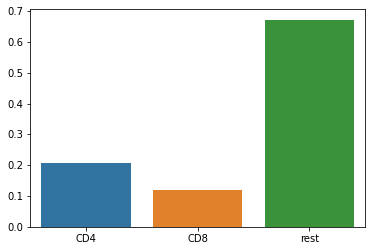

In [23]:
data = np.array(dfo.groupby("label").count()["pop"])
sns.barplot(y = data/np.sum(data),
           x=["CD4","CD8","rest"]);

# DRR analysis

In [24]:
df_unsup = dfo[(dfo["stim"] == "stimulated")&(dfo["pop"]=="Without")].sample(n=25000)

## UMAP

In [25]:
from umap import UMAP

In [26]:
umap = UMAP(n_neighbors=40)

In [27]:
umap_dims = umap.fit_transform(df_unsup[numeric_features])

In [28]:
umap_df = pd.DataFrame(umap_dims)

umap_df.columns = ["umap_dim_1","umap_dim_2"]
umap_df = pd.concat([umap_df, df_unsup.reset_index()],axis=1)

Text(0.5, 0.98, 'UMAP Analysis')

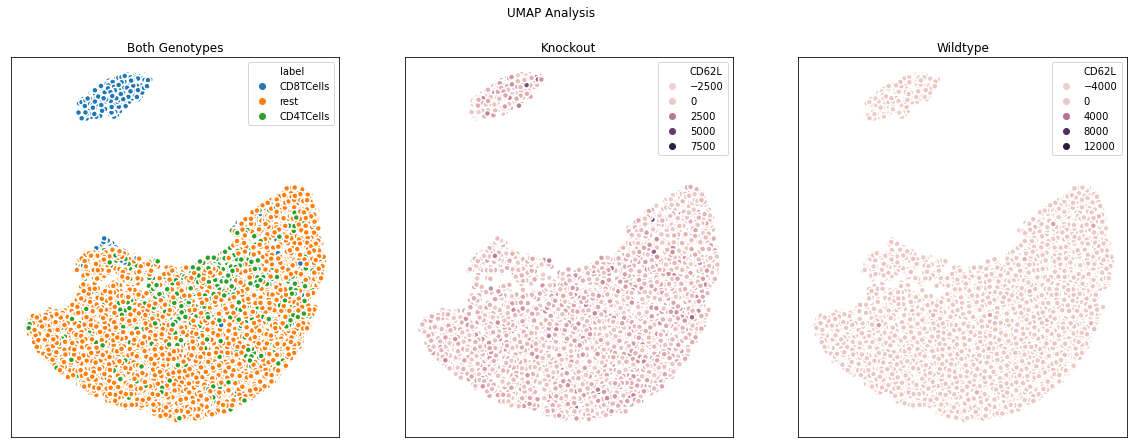

In [29]:
fig,ax = plt.subplots(1,3,figsize=(20,7))
sns.scatterplot(x="umap_dim_2", y="umap_dim_1", data = umap_df,hue="label", 
                     linewidth = 1.5,ax=ax[0])
sns.scatterplot(x="umap_dim_2", y="umap_dim_1", data = umap_df[umap_df["genotype"]=="KO"],hue="CD62L", 
                     linewidth = 1.5,ax=ax[1])
sns.scatterplot(x="umap_dim_2", y="umap_dim_1", data = umap_df[umap_df["genotype"]=="WT"],hue="CD62L", 
                     linewidth = 1.5,ax=ax[2])

ax[0].set_title("Both Genotypes")
ax[0].set_xlabel("")
ax[0].set_ylabel("")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_title("Knockout")
ax[1].set_xlabel("")
ax[1].set_ylabel("")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_title("Wildtype")
ax[2].set_xlabel("")
ax[2].set_ylabel("")
ax[2].set_xticks([])
ax[2].set_yticks([])
plt.suptitle("UMAP Analysis")


## tSNE

In [30]:
from sklearn.manifold import TSNE

In [31]:
tsne = TSNE(perplexity=50)

In [32]:
tsne_dims = tsne.fit_transform(X=df_unsup[numeric_features])

In [33]:
tsne_df = pd.DataFrame(tsne_dims)
tsne_df["genotype"] = list(df_unsup["genotype"])
tsne_df["population"] = list(df_unsup["pop"])
tsne_df["stim"] = list(df_unsup["stim"])
tsne_df["label"] = list(df_unsup["label"])
tsne_df.columns = ["tsne_dim_1","tsne_dim_2","genotype","population","stim","label"]

Text(0.5, 0.98, 'tSNE Analysis')

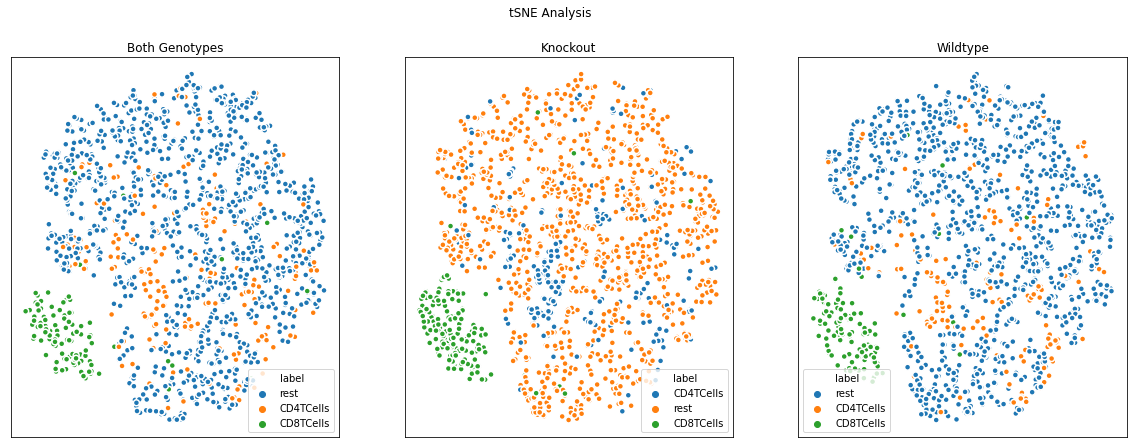

In [34]:
fig,ax = plt.subplots(1,3,figsize=(20,7))
sns.scatterplot(x="tsne_dim_2", y="tsne_dim_1", data = tsne_df.sample(n=1500),hue="label", 
                     linewidth = 1.5,ax=ax[0])
sns.scatterplot(x="tsne_dim_2", y="tsne_dim_1", data = tsne_df[tsne_df["genotype"]=="KO"].sample(n=1500),hue="label", 
                     linewidth = 1.5,ax=ax[1])
sns.scatterplot(x="tsne_dim_2", y="tsne_dim_1", data = tsne_df[tsne_df["genotype"]=="WT"].sample(n=1500),hue="label", 
                     linewidth = 1.5,ax=ax[2])

ax[0].set_title("Both Genotypes")
ax[0].set_xlabel("")
ax[0].set_ylabel("")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_title("Knockout")
ax[1].set_xlabel("")
ax[1].set_ylabel("")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_title("Wildtype")
ax[2].set_xlabel("")
ax[2].set_ylabel("")
ax[2].set_xticks([])
ax[2].set_yticks([])
plt.suptitle("tSNE Analysis")


# predictive modelling

In [35]:
def pop_model(df,gt,pop,x_list, y_label, model, top=3):
    konr = df[df["genotype"]==gt[0]]["mousenr"].unique()
    wtnr = df[df["genotype"]==gt[1]]["mousenr"].unique()
    
    df_train = df[df["mousenr"].isin(konr[:-1])|df["mousenr"].isin(wtnr[:-1])]
    df_val = df[df["mousenr"].isin(konr[-1:])|df["mousenr"].isin(wtnr[-1:])]
  
    df_pop_train = df_train[df_train["label"] == pop]
    df_pop_val = df_val[df_val["label"] == pop]
    
    X_train = df_pop_train[x_list]
    y_train = df_pop_train[y_label]
    X_val = df_pop_val[x_list]
    y_val = df_pop_val[y_label]
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    
    ax1=skplt.metrics.plot_confusion_matrix(y_val, y_pred, figsize=(10,10), text_fontsize=20, normalize = True)
    xlabels = ax1.get_xticklabels()
    ax1.set_xticklabels(xlabels,rotation=45)
    ax1.images[-1].colorbar.remove()
    
    skplt.estimators.plot_feature_importances(model, feature_names=x_list,max_num_features=20)
    plt.xticks(rotation=90)
    plt.show();
    
    fimp = sorted([(elm,numeric_features[idx]) for idx,elm in enumerate(model.feature_importances_)],reverse=True)
    
    fig, axs = plt.subplots(1,top,figsize=(9,3))
    for i in range(top):
        sns.barplot(x = df_pop_train.genotype.astype("object"), y = df_pop_train[fimp[i][1]], ax = axs[i] )
    plt.tight_layout()
    plt.show()
    
    print(classification_report(y_val, y_pred))

## CD8

### CD8 without

In [36]:
df_sup_wo = dfo[(dfo["stim"] == "stimulated")&(dfo["pop"]=="Without")]

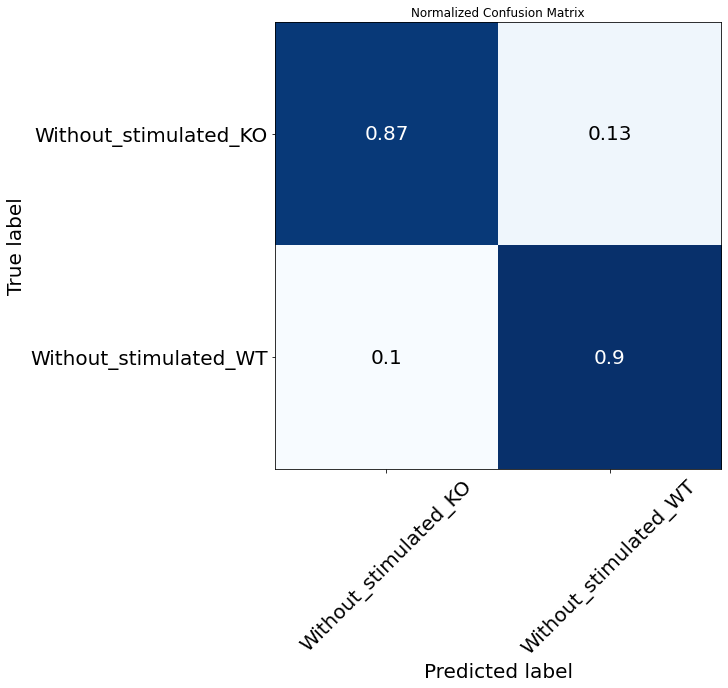

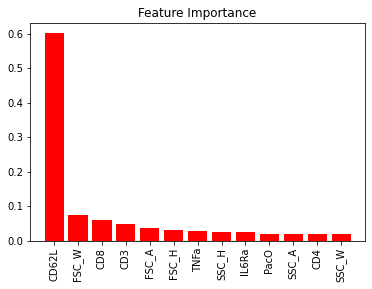

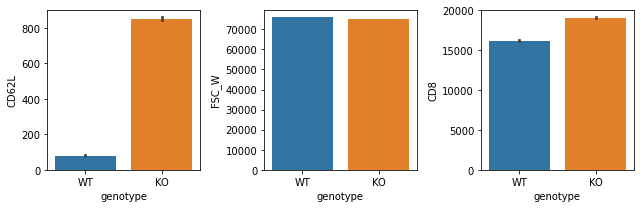

                       precision    recall  f1-score   support

Without_stimulated_KO       0.93      0.87      0.90     11749
Without_stimulated_WT       0.83      0.90      0.87      8315

             accuracy                           0.89     20064
            macro avg       0.88      0.89      0.88     20064
         weighted avg       0.89      0.89      0.89     20064



In [37]:
xgb_clf_cd8_wo = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_wo,["WT","KO"],"CD8TCells",numeric_features, "label2", xgb_clf_cd8_wo,3)

### CD8 GI

In [38]:
df_sup_gi = dfo[(dfo["stim"] == "stimulated")&(dfo["pop"]=="GI")]

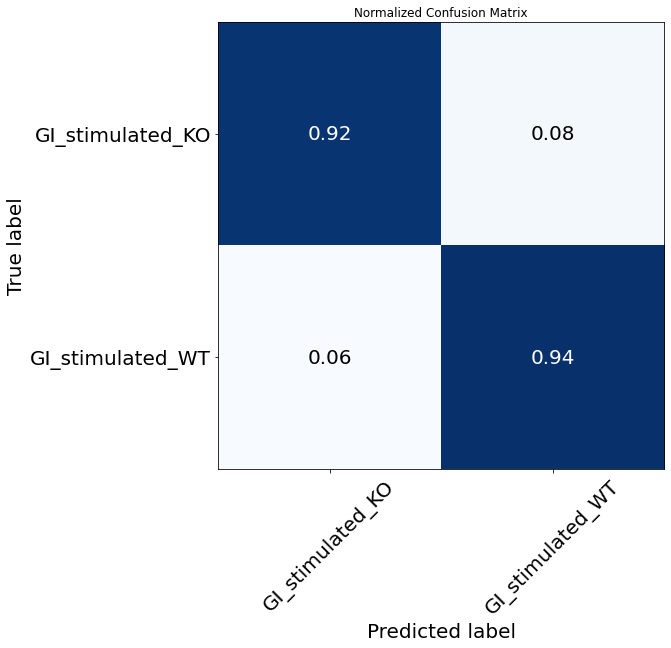

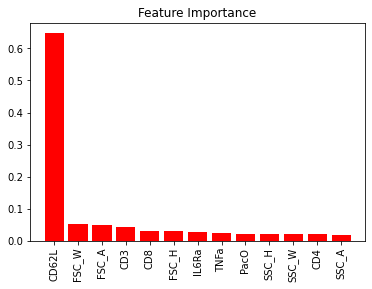

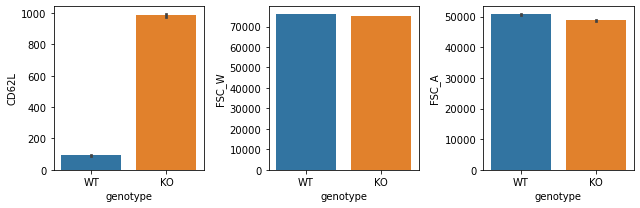

                  precision    recall  f1-score   support

GI_stimulated_KO       0.95      0.92      0.93     12730
GI_stimulated_WT       0.91      0.94      0.92     10923

        accuracy                           0.93     23653
       macro avg       0.93      0.93      0.93     23653
    weighted avg       0.93      0.93      0.93     23653



In [39]:
xgb_clf_cd8_gi = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_gi,["WT","KO"],"CD8TCells",numeric_features, "label2", xgb_clf_cd8_gi,3)

### CD8 gw

In [40]:
df_sup_gw = dfo[(dfo["stim"] == "stimulated")&(dfo["pop"]=="GW")]

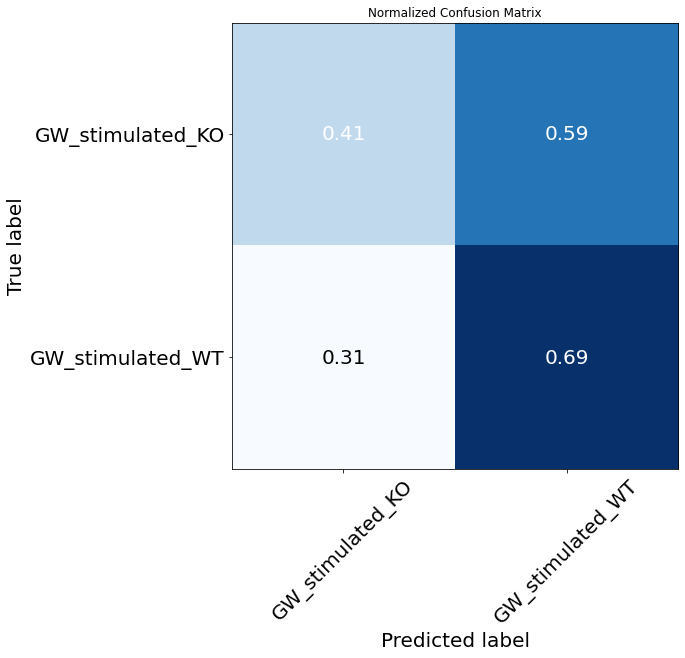

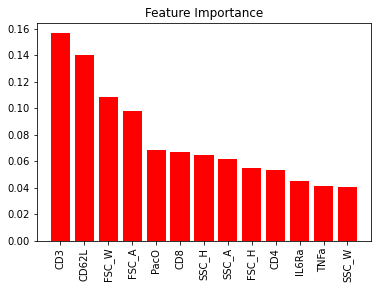

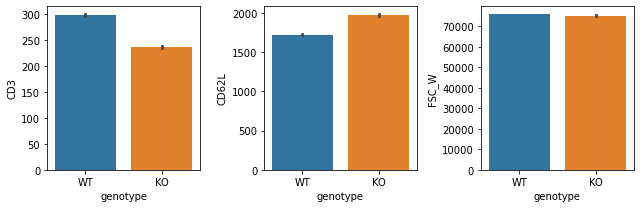

                  precision    recall  f1-score   support

GW_stimulated_KO       0.64      0.41      0.50     11743
GW_stimulated_WT       0.47      0.69      0.56      8754

        accuracy                           0.53     20497
       macro avg       0.55      0.55      0.53     20497
    weighted avg       0.56      0.53      0.52     20497



In [41]:
xgb_clf_cd8_gw = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_gw,["WT","KO"],"CD8TCells",numeric_features, "label2", xgb_clf_cd8_gw,3)

## CD4

### CD4 without

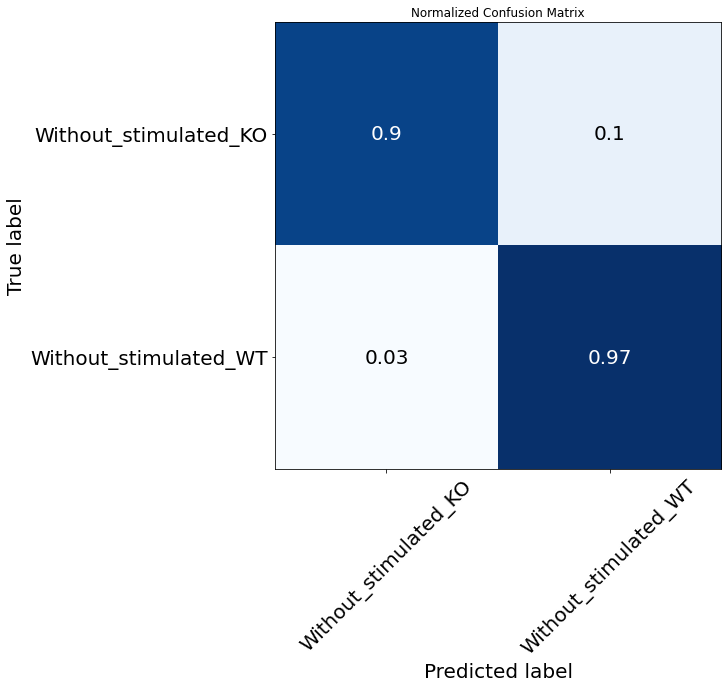

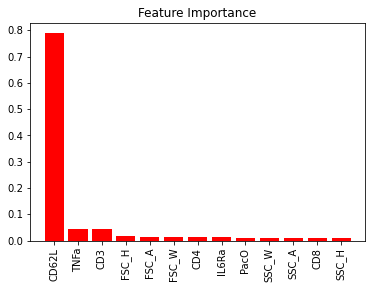

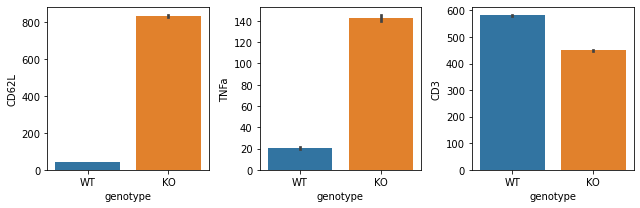

                       precision    recall  f1-score   support

Without_stimulated_KO       0.97      0.90      0.94     14798
Without_stimulated_WT       0.92      0.97      0.94     15737

             accuracy                           0.94     30535
            macro avg       0.94      0.94      0.94     30535
         weighted avg       0.94      0.94      0.94     30535



In [42]:
xgb_clf_cd4_wo = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_wo,["WT","KO"],"CD4TCells",numeric_features, "label2", xgb_clf_cd4_wo,3)

### CD4 GI

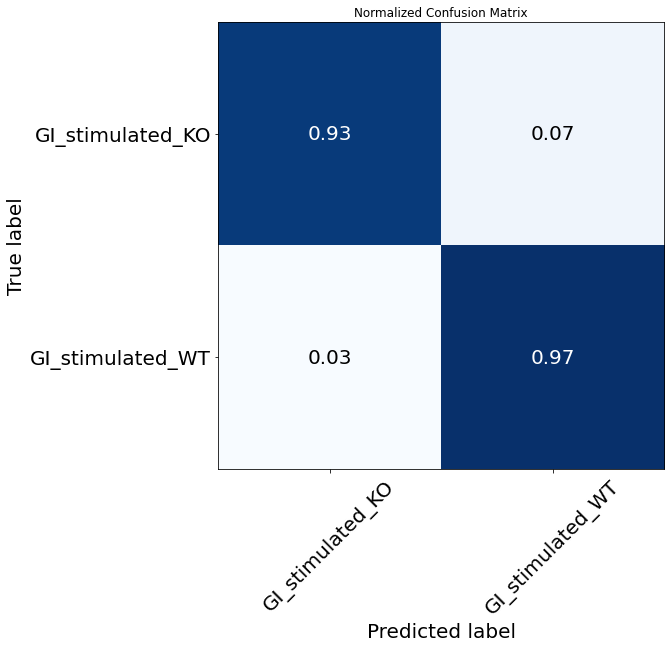

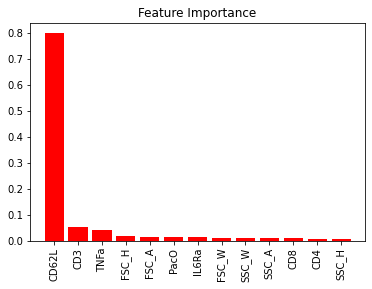

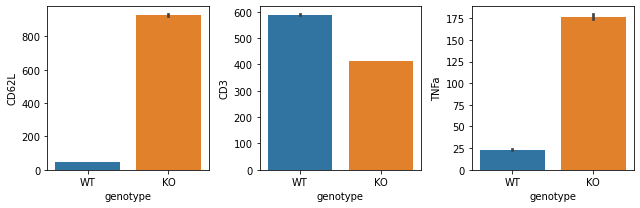

                  precision    recall  f1-score   support

GI_stimulated_KO       0.97      0.93      0.95     17428
GI_stimulated_WT       0.95      0.97      0.96     20494

        accuracy                           0.96     37922
       macro avg       0.96      0.95      0.96     37922
    weighted avg       0.96      0.96      0.96     37922



In [43]:
xgb_clf_cd4_gi = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_gi,["WT","KO"],"CD4TCells",numeric_features, "label2", xgb_clf_cd4_gi,3)

### CD4 gw

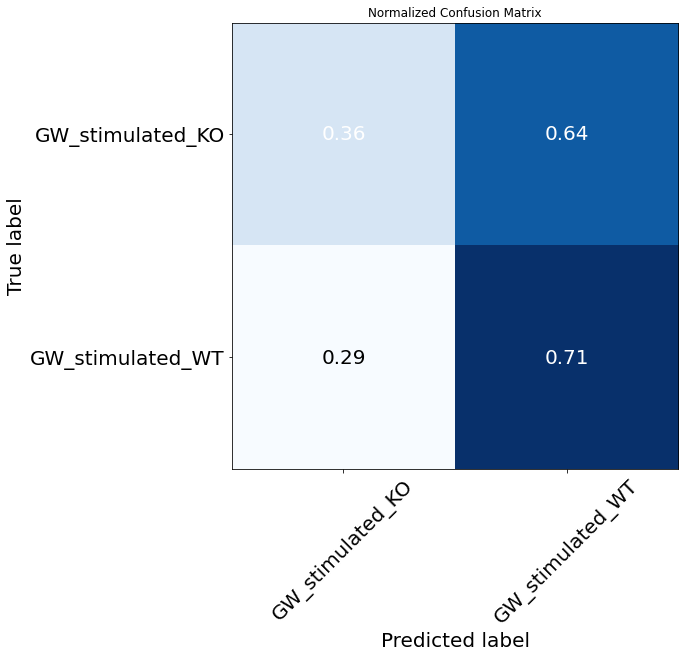

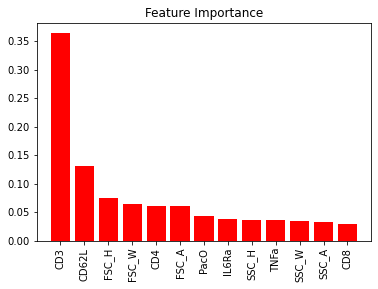

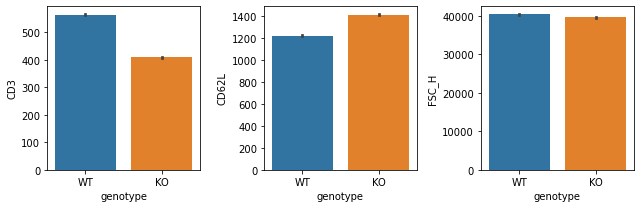

                  precision    recall  f1-score   support

GW_stimulated_KO       0.56      0.36      0.44     17369
GW_stimulated_WT       0.53      0.71      0.60     17241

        accuracy                           0.54     34610
       macro avg       0.54      0.54      0.52     34610
    weighted avg       0.54      0.54      0.52     34610



In [44]:
xgb_clf_cd4_gw = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_gw,["WT","KO"],"CD4TCells",numeric_features, "label2", xgb_clf_cd4_gw,3)

## rest

### rest without

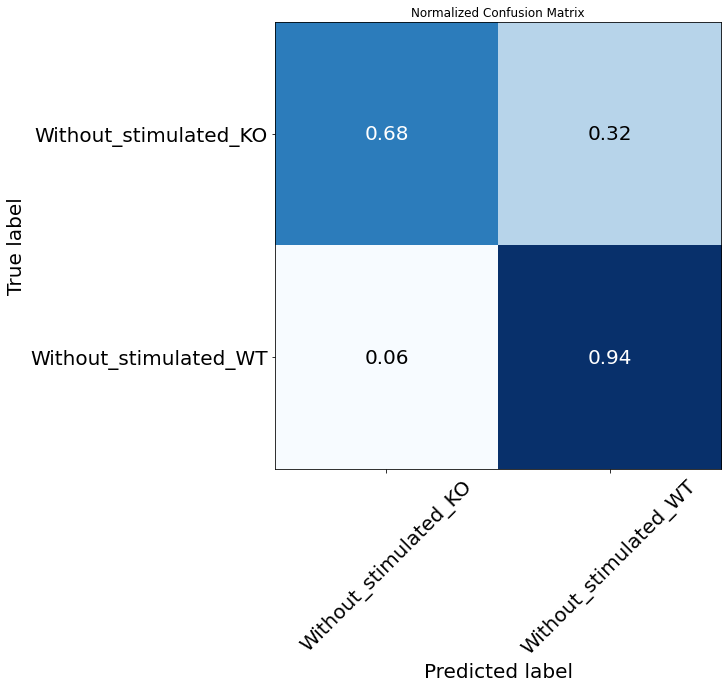

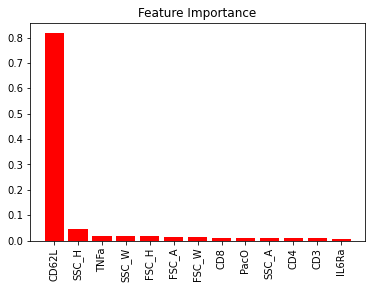

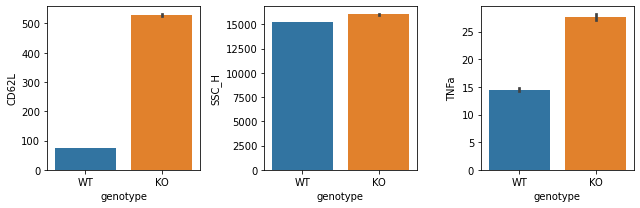

                       precision    recall  f1-score   support

Without_stimulated_KO       0.90      0.68      0.77     65961
Without_stimulated_WT       0.78      0.94      0.85     80039

             accuracy                           0.82    146000
            macro avg       0.84      0.81      0.81    146000
         weighted avg       0.83      0.82      0.82    146000



In [45]:
xgb_clf_rest_wo = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_wo,["WT","KO"],"rest",numeric_features, "label2", xgb_clf_rest_wo,3)

### rest GI

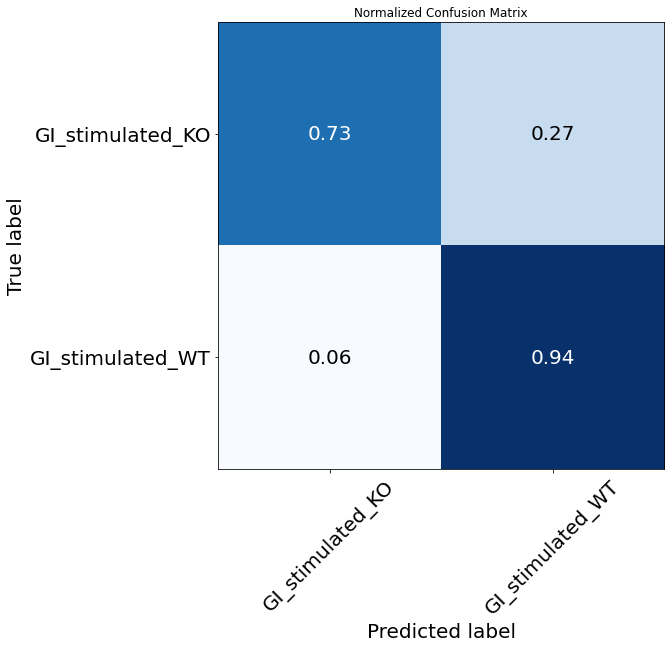

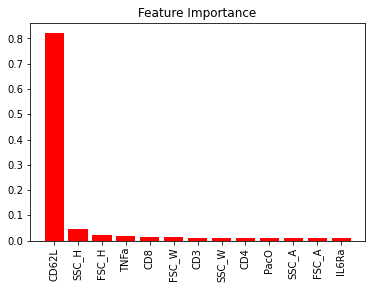

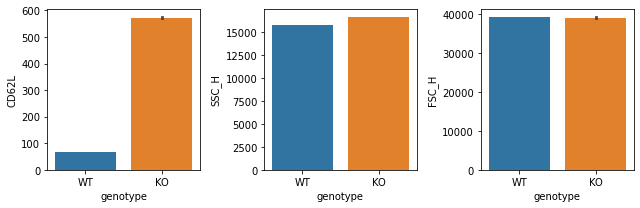

                  precision    recall  f1-score   support

GI_stimulated_KO       0.90      0.73      0.80     72799
GI_stimulated_WT       0.82      0.94      0.88     97913

        accuracy                           0.85    170712
       macro avg       0.86      0.83      0.84    170712
    weighted avg       0.86      0.85      0.85    170712



In [46]:
xgb_clf_rest_gi = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_gi,["WT","KO"],"rest",numeric_features, "label2", xgb_clf_rest_gi,3)

### rest gw

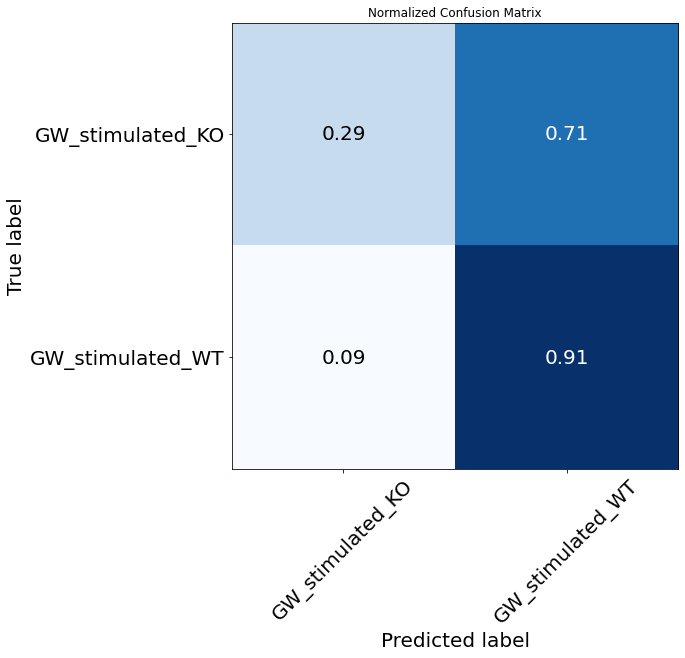

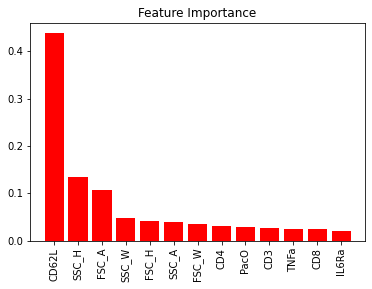

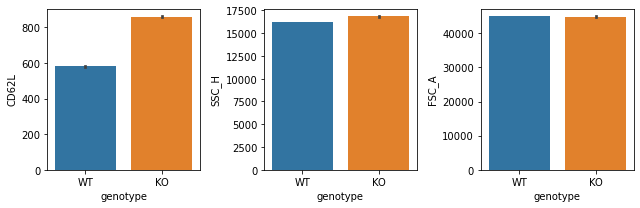

                  precision    recall  f1-score   support

GW_stimulated_KO       0.72      0.29      0.42     73841
GW_stimulated_WT       0.61      0.91      0.73     90223

        accuracy                           0.63    164064
       macro avg       0.67      0.60      0.57    164064
    weighted avg       0.66      0.63      0.59    164064



In [47]:
xgb_clf_rest_gw = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_gw,["WT","KO"],"rest",numeric_features, "label2", xgb_clf_rest_gw,3)

# test

In [48]:
df_test_wo = dfo[(dfo["stim"] == "stimulated")&(dfo["pop"]=="Without")]

In [49]:
def pop_model2(df,gt,pop,x_list, y_label, model, top=3):
    konr = df[df["genotype"]==gt[0]]["mousenr"].unique()
    wtnr = df[df["genotype"]==gt[1]]["mousenr"].unique()
    
    df_train = df[df["mousenr"].isin(konr[:-1])|df["mousenr"].isin(wtnr[:-1])]
    df_val = df[df["mousenr"].isin(konr[-1:])|df["mousenr"].isin(wtnr[-1:])]
  
    df_pop_train = df_train.copy()
    df_pop_val = df_val.copy()
    
    X_train = df_pop_train[x_list]
    y_train = df_pop_train[y_label]
    X_val = df_pop_val[x_list]
    y_val = df_pop_val[y_label]
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    
    ax1=skplt.metrics.plot_confusion_matrix(y_val, y_pred, figsize=(10,10), text_fontsize=20, normalize = True)
    xlabels = ax1.get_xticklabels()
    ax1.set_xticklabels(xlabels,rotation=45)
    ax1.images[-1].colorbar.remove()
    
    skplt.estimators.plot_feature_importances(model, feature_names=x_list,max_num_features=20)
    plt.xticks(rotation=90)
    plt.show();
    
    fimp = sorted([(elm,numeric_features[idx]) for idx,elm in enumerate(model.feature_importances_)],reverse=True)
    
    fig, axs = plt.subplots(1,top,figsize=(9,3))
    for i in range(top):
        sns.barplot(x = df_pop_train.genotype.astype("object"), y = df_pop_train[fimp[i][1]], ax = axs[i] )
    plt.tight_layout()
    plt.show()
    
    print(classification_report(y_val, y_pred))

In [ ]:
xgb_clf_rest_test = XGBClassifier(n_jobs = -1,random_state=42)
pop_model2(df_test_wo,["WT","KO"],"rest",numeric_features, "label2", xgb_clf_rest_test,3)